In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F

# 고정 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"


In [15]:
from collections import Counter
import numpy as np
import torch

def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])  # SN 하나만 불러옴
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue

        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue

        y_np = y.numpy()
        X_np = X.numpy()

        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue

        min_count = min(label_counts.values())
        indices = []

        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)

        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue

        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])

        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")

    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")

    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all


In [ ]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))  # SN001 ~ SN093
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))   # SN094 ~ SN123

✅ SN001 처리 완료: 클래스당 23개
✅ SN002 처리 완료: 클래스당 82개
✅ SN003 처리 완료: 클래스당 150개
✅ SN004 처리 완료: 클래스당 64개
✅ SN005 처리 완료: 클래스당 127개
✅ SN006 처리 완료: 클래스당 65개
✅ SN007 처리 완료: 클래스당 67개
✅ SN008 처리 완료: 클래스당 39개
✅ SN009 처리 완료: 클래스당 91개
✅ SN010 처리 완료: 클래스당 101개
✅ SN011 처리 완료: 클래스당 37개
✅ SN012 처리 완료: 클래스당 184개
✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀
✅ SN015 처리 완료: 클래스당 102개
✅ SN016 처리 완료: 클래스당 24개
✅ SN017 처리 완료: 클래스당 96개
✅ SN018 처리 완료: 클래스당 19개
✅ SN019 처리 완료: 클래스당 72개
✅ SN020 처리 완료: 클래스당 67개
✅ SN021 처리 완료: 클래스당 156개
✅ SN022 처리 완료: 클래스당 115개
✅ SN023 처리 완료: 클래스당 74개
✅ SN024 처리 완료: 클래스당 70개
✅ SN025 처리 완료: 클래스당 106개
✅ SN026 처리 완료: 클래스당 127개
✅ SN027 처리 완료: 클래스당 19개
✅ SN028 처리 완료: 클래스당 136개
✅ SN029 처리 완료: 클래스당 59개
✅ SN030 처리 완료: 클래스당 108개
✅ SN031 처리 완료: 클래스당 74개
✅ SN032 처리 완료: 클래스당 133개
✅ SN033 처리 완료: 클래스당 47개
✅ SN034 처리 완료: 클래스당 75개
✅ SN035 처리 완료: 클래스당 108개
✅ SN036 처리 완료: 클래스당 87개
✅ SN037 처리 완료: 클래스당 65개
✅ SN038 처리 완료: 클래스당 61개
✅ SN039 처리 완료: 클래스당 108개
✅ SN040 처리 완료: 클래스당 62개
✅ SN041 처리 완료

In [ ]:
print("✅ 균형 조정 후 라벨 분포:", Counter(y_train.numpy()))
print("✅ 균형 조정 후 라벨 분포:", Counter(y_val.numpy()))


✅ 균형 조정 후 라벨 분포: Counter({np.int64(3): 7391, np.int64(0): 7391, np.int64(1): 7391, np.int64(2): 7211})
✅ 균형 조정 후 라벨 분포: Counter({np.int64(0): 2217, np.int64(1): 2217, np.int64(2): 2217, np.int64(3): 2134})
✅ 균형 조정 후 라벨 분포: Counter({np.int64(0): 2324, np.int64(3): 2324, np.int64(2): 2324, np.int64(1): 2324})


In [2]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")

        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue

        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()

        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()

        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)

        # ⚠️ 반드시 가능한 segment 수 계산 후 최소로 맞춤
        max_possible_segments = len(ecg_signal) // segment_length
        num_segments = min(len(label_seq), max_possible_segments)

        ecg_segments = []
        for i in range(num_segments):
            start = i * segment_length
            end = start + segment_length
            segment = ecg_signal[start:end]
            segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
            ecg_segments.append(segment)

        all_segments.extend(ecg_segments)
        all_labels.extend(label_seq[:num_segments])

    # 텐서 변환
    X = torch.tensor(np.array(all_segments), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y


In [24]:
# train: SN001 ~ SN093
#X_train, y_train = load_data_from_sn(list(range(1, 93)))

# validation: SN094 ~ SN123
#X_val, y_val = load_data_from_sn(list(range(94, 123)))

# test: SN124 ~ SN154
X_test, y_test = load_data_from_sn(list(range(124, 154)))

print("✅ 학습 데이터:", X_train.shape, y_train.shape)
print("✅ validation 데이터:", X_val.shape, y_val.shape)
print("✅ 테스트 데이터:", X_test.shape, y_test.shape)


❌ 파일 없음: SN135
✅ 학습 데이터: torch.Size([29384, 1, 7680]) torch.Size([29384])
✅ validation 데이터: torch.Size([8785, 1, 7680]) torch.Size([8785])
✅ 테스트 데이터: torch.Size([26866, 1, 7680]) torch.Size([26866])


In [4]:
import torch
from collections import Counter

print("📊 Train 라벨 분포:", Counter(y_train.numpy()))


📊 Train 라벨 분포: Counter({np.int64(1): 39927, np.int64(2): 15415, np.int64(0): 13928, np.int64(3): 13136})


In [9]:
import torch
import numpy as np
from collections import Counter

# 라벨 numpy로 변환
y_np = y_train.numpy()
X_np = X_train.numpy()

# 라벨별 인덱스 수 세기
label_counts = Counter(y_np)
min_count = min(label_counts.values())  # 가장 작은 라벨 수 (ex: 13136)

# 균형 맞춘 인덱스 수집
balanced_indices = []
for label in sorted(label_counts.keys()):
    label_indices = np.where(y_np == label)[0]
    sampled_indices = np.random.choice(label_indices, min_count, replace=False)
    balanced_indices.extend(sampled_indices)

# 섞기
np.random.shuffle(balanced_indices)

# 샘플링된 데이터로 새 tensor 생성
X_train_resample = torch.tensor(X_np[balanced_indices], dtype=torch.float32)
y_train_resample = torch.tensor(y_np[balanced_indices], dtype=torch.long)

# 저장 (원한다면)
#torch.save((X_train_bal, y_train_bal), "CNN_train_balanced.pt")

# 라벨 확인
print("✅ 균형 조정 후 라벨 분포:", Counter(y_train_resample.numpy()))


✅ 균형 조정 후 라벨 분포: Counter({np.int64(2): 13136, np.int64(1): 13136, np.int64(3): 13136, np.int64(0): 13136})


In [6]:
import torch
from collections import Counter

print("📊 Validation 라벨 분포:", Counter(y_val.numpy()))


📊 Validation 라벨 분포: Counter({np.int64(1): 11828, np.int64(0): 5066, np.int64(2): 4877, np.int64(3): 3670})


In [11]:
# 라벨 numpy로 변환
y_np = y_val.numpy()
X_np = X_val.numpy()

# 라벨별 인덱스 수 세기
label_counts = Counter(y_np)
min_count = min(label_counts.values())  # 가장 작은 라벨 수 (ex: 13136)

# 균형 맞춘 인덱스 수집
balanced_indices = []
for label in sorted(label_counts.keys()):
    label_indices = np.where(y_np == label)[0]
    sampled_indices = np.random.choice(label_indices, min_count, replace=False)
    balanced_indices.extend(sampled_indices)

# 섞기
np.random.shuffle(balanced_indices)

# 샘플링된 데이터로 새 tensor 생성
X_val_resample = torch.tensor(X_np[balanced_indices], dtype=torch.float32)
y_val_resample = torch.tensor(y_np[balanced_indices], dtype=torch.long)

# 라벨 확인
print("✅ 균형 조정 후 라벨 분포:", Counter(y_val_resample.numpy()))


✅ 균형 조정 후 라벨 분포: Counter({np.int64(1): 3670, np.int64(0): 3670, np.int64(3): 3670, np.int64(2): 3670})


/home/mhb0917/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mhb0917/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mhb0917/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mhb0917/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mhb0917/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu

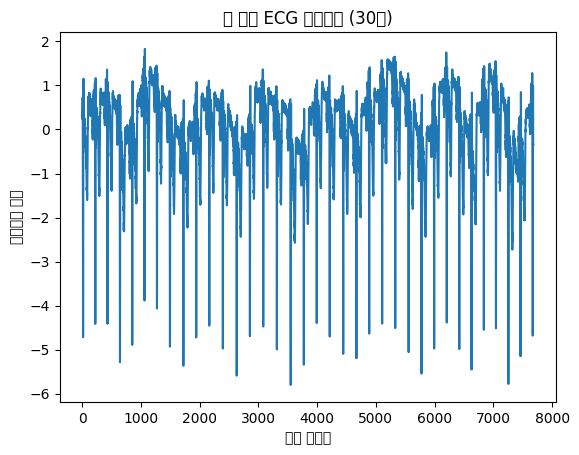

In [9]:
import matplotlib.pyplot as plt

plt.plot(X_train[12000][0][:].numpy())  # 첫 번째 세그먼트의 ECG 시계열
plt.title("첫 번째 ECG 세그먼트 (30초)")
plt.xlabel("샘플 인덱스")
plt.ylabel("정규화된 전압")
plt.show()

In [20]:
print("🧪 X_train shape:", X_train.shape)
print("🧪 y_train shape:", y_train.shape)


🧪 X_train shape: torch.Size([29384, 1, 7680])
🧪 y_train shape: torch.Size([29384])


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import numpy as np

# 🔹 모델 정의
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 960, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [22]:
# 🔹 EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"🔁 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
import torch, random, numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 🔹 데이터로더 설정
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# 🔹 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🔹 학습 루프 
for epoch in range(50):  # 최대 50 epoch
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    train_acc = 100 * correct / total

    # 🔹 검증 단계
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


📘 Epoch 1 | Train Loss: 1271.4043 | Train Acc: 28.33% | Val Loss: 1.3514 | Val Acc: 29.07%
📘 Epoch 2 | Train Loss: 1221.2911 | Train Acc: 31.45% | Val Loss: 1.3399 | Val Acc: 32.05%
📘 Epoch 3 | Train Loss: 1192.2901 | Train Acc: 33.74% | Val Loss: 1.3279 | Val Acc: 32.91%
📘 Epoch 4 | Train Loss: 1174.5512 | Train Acc: 35.59% | Val Loss: 1.3415 | Val Acc: 32.38%
🔁 EarlyStopping counter: 1/10
📘 Epoch 5 | Train Loss: 1147.5467 | Train Acc: 37.45% | Val Loss: 1.3805 | Val Acc: 32.42%
🔁 EarlyStopping counter: 2/10
📘 Epoch 6 | Train Loss: 1111.3826 | Train Acc: 40.57% | Val Loss: 1.4139 | Val Acc: 32.13%
🔁 EarlyStopping counter: 3/10
📘 Epoch 7 | Train Loss: 1067.1297 | Train Acc: 43.77% | Val Loss: 1.4183 | Val Acc: 32.34%
🔁 EarlyStopping counter: 4/10
📘 Epoch 8 | Train Loss: 1005.6958 | Train Acc: 47.69% | Val Loss: 1.5295 | Val Acc: 31.83%
🔁 EarlyStopping counter: 5/10
📘 Epoch 9 | Train Loss: 942.0991 | Train Acc: 51.29% | Val Loss: 1.4997 | Val Acc: 32.95%
🔁 EarlyStopping counter: 6/10
📘 

In [20]:
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    xb = xb.to(device)
    outputs = model(xb)
    probs = torch.softmax(outputs, dim=1)
    print("📊 예측 확률(softmax):", probs[:5].cpu().numpy())
    print("📌 예측 라벨:", torch.argmax(probs, dim=1)[:5].cpu().numpy())
    print("✅ 실제 라벨:", yb[:5].numpy())


📊 예측 확률(softmax): [[0.11925616 0.25573042 0.3289412  0.29607224]
 [0.17724027 0.27588347 0.23655592 0.31032038]
 [0.7796695  0.1835068  0.02532148 0.01150226]
 [0.01012473 0.29531756 0.21957608 0.4749817 ]
 [0.33750275 0.24115986 0.24195588 0.17938145]]
📌 예측 라벨: [2 3 0 3 0]
✅ 실제 라벨: [1 0 3 2 3]


In [21]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


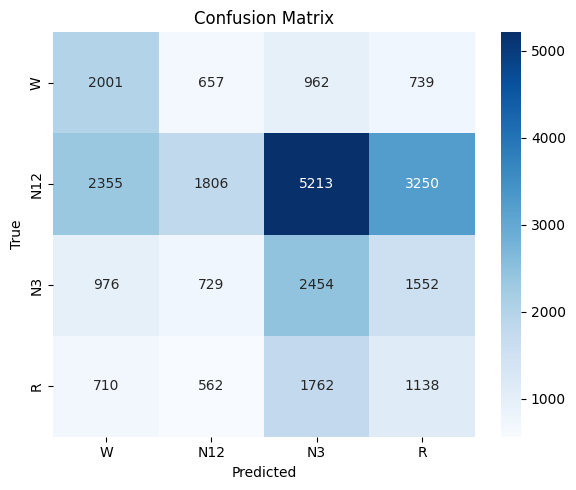

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.33      0.46      0.38      4359
         N12       0.48      0.14      0.22     12624
          N3       0.24      0.43      0.30      5711
           R       0.17      0.27      0.21      4172

    accuracy                           0.28     26866
   macro avg       0.30      0.33      0.28     26866
weighted avg       0.36      0.28      0.26     26866



In [22]:
labels = ['W', 'N12', 'N3', 'R']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
